<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />

# Worksheet 5.1: DGA Detection using Machine Learning - Answers
 
This worksheet covers concepts covered in Module 5 - Supervised Learning. Train and evaluate a classification model using [sklearn](http://scikit-learn.org/stable/). It should take no more than 40-60 minutes to complete.  Please raise your hand if you get stuck.  

This notebook is a step-by-step guide on how to detect domains that were generated using "Domain Generation Algorithm" (DGA). We will walk you through the process of creating a decision tree classifer which you will use to determine whether a given domain is legit or not. Once you have implemented the classifier, the worksheet will walk you through evaluating your model and getting interpretable results for predictions.   


1. **Feature Engineering** - Completed in Module 4
2. **Machine Learning Classification** - predict whether a domain is legit or not using a Decision Tree Classifier

## Import the Libraries
For this exercise, we will be using:
* Pandas (http://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (http://matplotlib.org/api/pyplot_api.html)
* Scikit-learn (http://scikit-learn.org/stable/documentation.html)
* [Lime](https://github.com/marcotcr/lime)
* [SHAP](https://shap.readthedocs.io/en/latest/index.html)

In [59]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
from sklearn import feature_extraction, tree, model_selection, metrics
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
import pydotplus as pydot

import lime
import shap

DATA_HOME = '../data'
shap.initjs()

import io
import pickle
import warnings
warnings.filterwarnings('ignore')

## Load Features and Labels

If you got stuck in the Feature Engineering section, please simply uncomment the code below to load the feature matrix we prepared for you, so you can move on to train a Decision Tree Classifier.

In [43]:
#load full dataset
df_final = pd.read_csv('../data/dga_features_final_df.csv')

#If you didn't get a working dataset from module 4, uncomment the line below
#df_final = pd.read_csv('../data/our_data_dga_features_final_df.csv')

df_final.head()

,isDGA,length,digits,entropy,vowel-cons,firstDigitIndex,ngrams
0,dga,13,0,3.546594,0.083333,0,744.670940
1,dga,26,10,4.132944,0.333333,1,715.217265
2,dga,8,0,2.500000,0.333333,0,1918.797619
3,dga,26,7,4.180833,0.357143,1,682.269402
4,dga,24,9,3.834963,0.666667,2,544.178140


In [44]:
print(df_final['isDGA'].value_counts())

isDGA
dga      1000
legit    1000
Name: count, dtype: int64


## Prepare the ```feature_matrix``` and ```target``` 

- In statistics and machine learning, the ```feature_matrix``` is often referred to as ```X```
- The target vector that contains the labels for each row is called ```y``` 
- In sklearn both the features and targets can either be a pandas DataFrame/Series or numpy array/vector respectively (can't be lists!)

Tasks:
- Create a vector that contains the **target**s
- Create the **feature_matrix** that has only the features and not the targets 

## Create a vector named 'target' 

Assign the **isDGA** column to a pandas Series named **target**. The ```target``` variable should be a vector (1 dimension) of the correct (ground truth) answer for each row of the dataset. For this DGA use case, each item will be a string that indicates whether the domain was **dga** or **legit**. 

In [45]:
target = df_final['isDGA']
target.head()

0    dga
1    dga
2    dga
3    dga
4    dga
Name: isDGA, dtype: object

## Create the Feature Matrix

In order to train a model you have to separate the features from the targets. Create the ```feature_matrix``` (pandas dataframe) by dropping the **isDGA** column from ```df_final```.

In [46]:
feature_matrix = df_final.drop(columns=['isDGA'])
feature_matrix.head()

,length,digits,entropy,vowel-cons,firstDigitIndex,ngrams
0,13,0,3.546594,0.083333,0,744.670940
1,26,10,4.132944,0.333333,1,715.217265
2,8,0,2.500000,0.333333,0,1918.797619
3,26,7,4.180833,0.357143,1,682.269402
4,24,9,3.834963,0.666667,2,544.178140


Creata a list of our feature names for plotting later and if we need to pull the features again from the full dataframe.


In [47]:
feature_names = feature_matrix.columns.to_list()
print(feature_names)

['length', 'digits', 'entropy', 'vowel-cons', 'firstDigitIndex', 'ngrams']


# Test-Train split

Split (the dataset) your ```feature_matrix``` and ```target``` into **train** and **test** subsets using sklearn [model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Output of the split should be 2 complete sets of data (**train** and **test** that are still separated into features and labels: 
 - **feature_matrix_train**: 75% of the feature matrix (data)
 - **feature_matrix_test**: the remaining 25% of the feature matrix
 - **target_train**: the labels for the train features
 - **target_test**: the labels for the test features

In [48]:
feature_matrix_train, feature_matrix_test, target_train, target_test = (model_selection.
                                                                        train_test_split(
                                                                           feature_matrix, 
                                                                           target,
                                                                           test_size=0.25, 
                                                                           random_state=33))

In [49]:
feature_matrix_train.shape

(1500, 6)

In [50]:
feature_matrix_test.shape

(500, 6)

In [51]:
target_train[1:5]

1529    legit
1125    legit
1739    legit
1303    legit
Name: isDGA, dtype: object

In [52]:
target_test[1:5]

182       dga
1763    legit
1814    legit
596       dga
Name: isDGA, dtype: object

# Train the model and make a prediction

Finally, we have prepared and split the data. Let's start classifying!!   

Tasks:
-  Use the sklearn [tree.DecisionTreeClassfier()](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), instantiate (create) a decision tree model with default parameters (we will tune these in the next lab).
- Train this model using the ```feature_matrix_train``` and ```target_train``` data (you will need to call the **.fit()** method on the model to do this).
-  Next, pull a few random rows from the data to spot check the predictions of the model against the true labels.

In [53]:
d_tree_model = tree.DecisionTreeClassifier()  
d_tree_model = d_tree_model.fit(feature_matrix_train, target_train)

That's it! You trained the model. Now extract a row from the test set to see if the model can predict the correct answer by comparing it to the test target (ground truth). 

In [54]:
# Extract a row from the test data

row_number = 14
row_feature = feature_matrix_test[row_number:row_number+1]

# Make the prediction
row_pred = d_tree_model.predict(row_feature)

# pull out the ground truth for this row
row_target = target_test[row_number:row_number+1]
                                                    
# print the results and the ground truth
print('Predicted class:', row_pred)
print('Ground truth class:', row_target)
print('Accurate prediction?', row_pred == row_target)

Predicted class: ['legit']
Ground truth class: 1314    legit
Name: isDGA, dtype: object
Accurate prediction? 1314    True
Name: isDGA, dtype: bool


# Make predictions on test set

Make predictions for all your **test** data. This will be data that the model has not 'seen' before so we will use these predictions to evaluate how well the model can predict the correct answer on new data by calling a few different metrics functions.

- Call the ```.predict()``` method on the model ```d_tree_model``` with your test data ```feature_matrix_test``` and store the results in a variable called ```test_predictions```. 
  
- Then calculate the **accuracy** (and several other metris) using ```target_test``` (which are the true labels/ground truth) AND your models predictions on the test portion ```test_predictions``` as inputs. 

In [55]:
# make predictions on all of the test data
test_predictions = d_tree_model.predict(feature_matrix_test)

# print a sample of the predictions
print(test_predictions[0:5])

['dga' 'dga' 'legit' 'legit' 'dga']


#### Save the model as a pickle file

In [60]:
filename = f'{DATA_HOME}/dga_decision_tree.pkl'
pickle.dump(d_tree_model, open(filename, 'wb'))

# Evaluate the model performance with metrics and visualizations

## Print metrics
Use sklearn [metrics.accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to calculate the model accuracy. 

In [16]:
print("Accuracy:", metrics.accuracy_score(target_test, test_predictions))

Accuracy: 0.884


In [17]:
print(metrics.classification_report(target_test, test_predictions))

              precision    recall  f1-score   support

         dga       0.86      0.91      0.88       244
       legit       0.91      0.86      0.88       256

    accuracy                           0.88       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.88      0.88       500



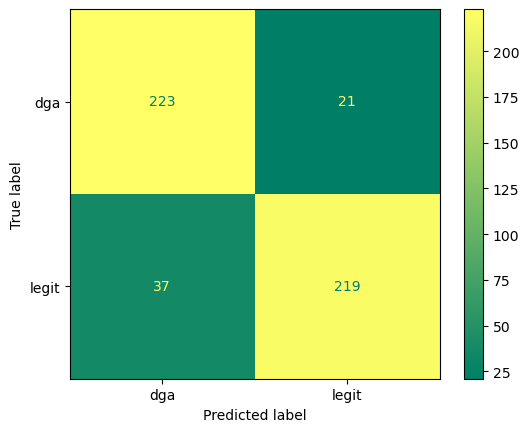

In [18]:
conf_matrix = metrics.confusion_matrix(target_test, test_predictions, labels=d_tree_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=d_tree_model.classes_)

disp.plot(cmap='summer');

## (Optional) Visualizing your Tree
As an optional step, you can actually visualize your tree.  The following code will generate a graph of your decision tree.  You will need graphviz (http://www.graphviz.org) and pydotplus (or pydot) installed for this to work.

In [19]:
dot_data = io.StringIO() 
tree.export_graphviz(d_tree_model, out_file=dot_data, 
                     feature_names=feature_names,
                    filled=True, rounded=True,  
                    special_characters=True) 

graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())


InvocationException: GraphViz's executables not found

# Explain a model
Two methods for explaining a model. 

## Method 1: feature importance - impunity decrease

In Sci-kit Learn tree (and other) models, feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.


In [ ]:
importances = d_tree_model.feature_importances_

d_tree_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
d_tree_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Method 2: Feature Importance using feature permutation

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.


In [20]:
result = permutation_importance(
    d_tree_model, feature_matrix_test, target_test, n_repeats=10, random_state=42, n_jobs=2
)

perm_importances = pd.Series(result.importances_mean, index=feature_names)

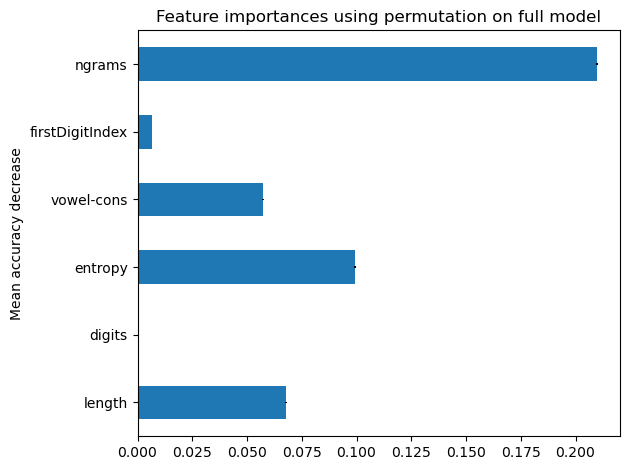

In [21]:
fig, ax = plt.subplots()
perm_importances.plot.barh(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

## Method3: SHAP



In [22]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(d_tree_model.predict_proba, feature_matrix_train)
shap_values = explainer.shap_values(feature_matrix_test)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], feature_matrix_test)

Using 1500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/500 [00:00<?, ?it/s]

# Explaining a specific prediction: SHAP
In the example below, you can use SHAP to explain how a classifier arrived at its prediction.  Try running SHAP with the  classifier you've created and various rows to see how it functions. 

In [23]:
# choose an item from the test set and print the values
sample_number = 20
print('true_label =', target_test.iloc[sample_number])
feature_matrix_test.iloc[sample_number]

true_label = legit


length               6.000000
digits               0.000000
entropy              2.251629
vowel-cons           0.000000
firstDigitIndex      0.000000
ngrams             485.444444
Name: 1133, dtype: float64

In [24]:
# explain the model's prediction on the sample we just printed above using shap

explainer = shap.KernelExplainer(d_tree_model.predict_proba, feature_matrix_train)
shap_values = explainer.shap_values(feature_matrix_test.iloc[sample_number])
shap.force_plot(explainer.expected_value[0], shap_values[:, 0], feature_matrix_test.iloc[sample_number])

Using 1500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


### Explain a prediction: LIME
Lime is similar to SHAP in that it can help us understand what features were used/influencial in the decision of a prediction. 

In [25]:
explainer = lime.lime_tabular.LimeTabularExplainer(feature_matrix_train, 
                                                   feature_names=feature_names, 
                                                  class_names=d_tree_model.classes_, 
                                                   discretize_continuous=False)

Let's look at the explanation for one data point (row) from the test set. 

Now we will call the explainer on this sample to see what the model was using to get it's prediction

In [26]:
exp = explainer.explain_instance(feature_matrix_test.iloc[sample_number], 
                                 d_tree_model.predict_proba, 
                                 num_features=6)

In [27]:
exp.as_list()

[('entropy', -0.19743219645241838),
 ('ngrams', 0.15563321249444761),
 ('length', -0.1376067431574928),
 ('vowel-cons', 0.08809755725956482),
 ('firstDigitIndex', 0.03771979281288239),
 ('digits', 0.0042813204053924435)]

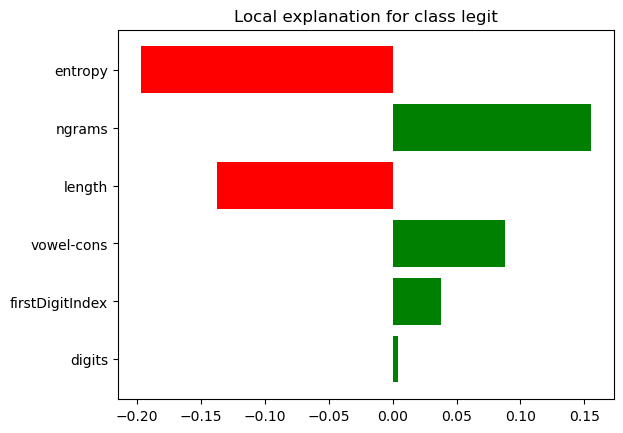

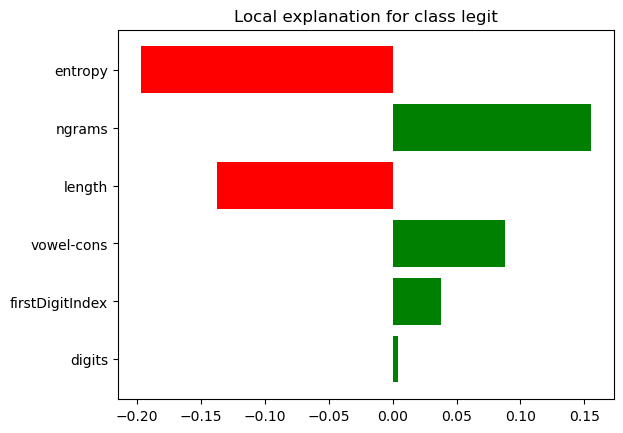

In [28]:
exp.as_pyplot_figure()

In [29]:
#exp.show_in_notebook(show_table=True, show_all=True)

#  Train and evaluate more models
Now that you've built a Decision Tree, let's try out two other classifiers and see how they perform on this data.  For this next exercise, create classifiers using:

* Support Vector Machine
* Random Forest
* K-Nearest Neighbors (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)  

Once you've done that, run the various performance metrics to determine which classifier works best.

## Create the Random Forest Classifier

In [30]:
random_forest_clf = RandomForestClassifier(n_estimators=10, 
                             max_depth=None, 
                             min_samples_split=2, 
                             random_state=0)

random_forest_clf = random_forest_clf.fit(feature_matrix_train, target_train)

#### Make predictions

In [31]:
random_forest_test_predictions = random_forest_clf.predict(feature_matrix_test)

#### Metrics

In [32]:
print("Accuracy:", metrics.accuracy_score(target_test, random_forest_test_predictions))

Accuracy: 0.902


In [33]:
print(metrics.classification_report(target_test, random_forest_test_predictions))

              precision    recall  f1-score   support

         dga       0.89      0.91      0.90       244
       legit       0.91      0.90      0.90       256

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



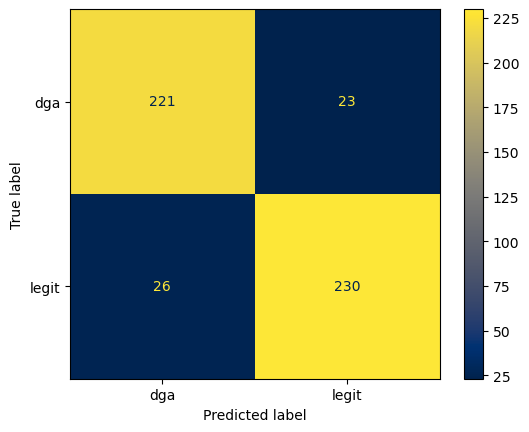

In [34]:
rf_conf_matrix = metrics.confusion_matrix(target_test, random_forest_test_predictions, labels=random_forest_clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=rf_conf_matrix,
                              display_labels=random_forest_clf.classes_)

disp.plot(cmap='cividis');

### Feature Importance

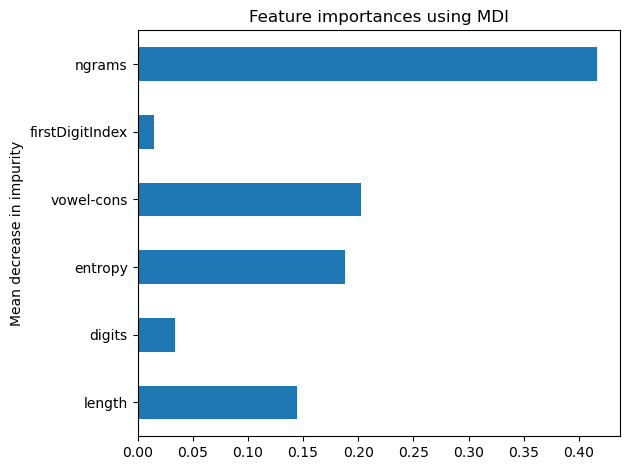

In [35]:
importances = random_forest_clf.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [36]:
rf_result = permutation_importance(
    random_forest_clf, feature_matrix_test, target_test, n_repeats=10, random_state=42, n_jobs=2
)

rf_importances = pd.Series(result.importances_mean, index=feature_names)

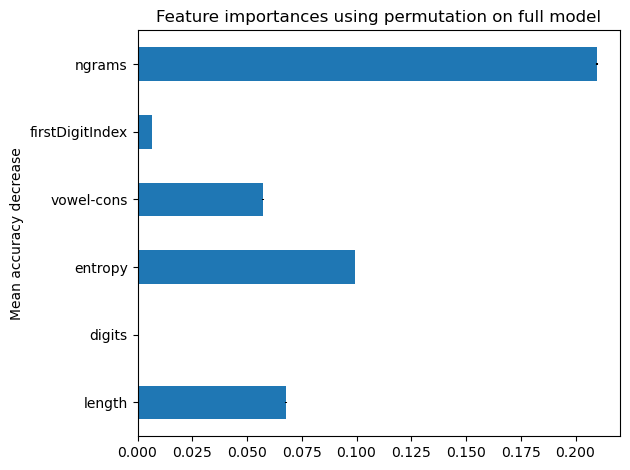

In [37]:
fig, ax = plt.subplots()
rf_importances.plot.barh(yerr=rf_result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

## Train a SVM classifier


In [38]:
from sklearn import svm

svm_classifier = svm.SVC()
svm_classifier = svm_classifier.fit(feature_matrix_train, target_train)  

#### Make predictions on the test set

In [39]:
svm_test_predictions = svm_classifier.predict(feature_matrix_test)

#### Metrics

In [40]:
print("SVM Accuracy:", metrics.accuracy_score(target_test, svm_test_predictions))

SVM Accuracy: 0.824


In [41]:
print(metrics.classification_report(target_test, svm_test_predictions))

              precision    recall  f1-score   support

         dga       0.82      0.82      0.82       244
       legit       0.83      0.83      0.83       256

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



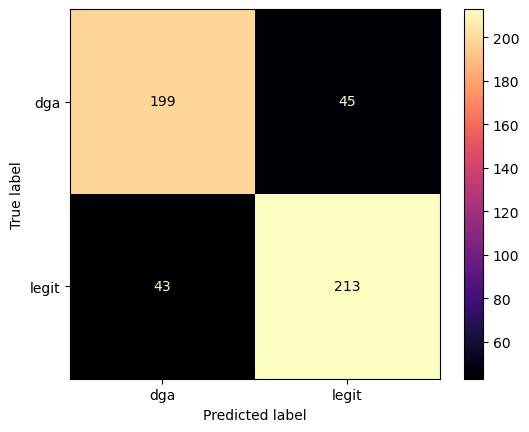

In [42]:
svm_conf_matrix = metrics.confusion_matrix(target_test, svm_test_predictions, labels=svm_classifier.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=svm_conf_matrix,
                              display_labels=svm_classifier.classes_)

disp.plot(cmap='magma');

## Train a K-Nearest Neighbors Classifier

In [43]:
knn_clf = KNeighborsClassifier()
knn_clf = knn_clf.fit(feature_matrix_train, target_train) 

#### Make predictions

In [44]:
knn_test_predictions = knn_clf.predict(feature_matrix_test)

#### Metrics

In [45]:
print("KNN Accuracy:", metrics.accuracy_score(target_test, knn_test_predictions))

KNN Accuracy: 0.848


In [46]:
print(metrics.classification_report(target_test, knn_test_predictions))

              precision    recall  f1-score   support

         dga       0.84      0.85      0.85       244
       legit       0.86      0.84      0.85       256

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500



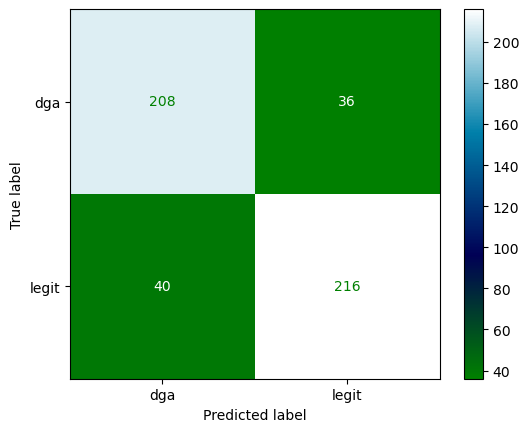

In [47]:
knn_conf_matrix = metrics.confusion_matrix(target_test, knn_test_predictions, labels=knn_clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=knn_conf_matrix,
                                       display_labels=knn_clf.classes_)

disp.plot(cmap='ocean');